### Library

- [Roboflow Data](https://universe.roboflow.com/university-of-strathclyde-m436x/pcb-defect-94yfu/dataset/1)

In [1]:
!pip install ultralytics

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import torch
import yaml
import warnings
from ultralytics import YOLO
from tqdm import tqdm
from pathlib import Path
warnings.filterwarnings('ignore')
import sys

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# 환경에 따라 PROJECT_ROOT 설정
if IN_COLAB:
    PROJECT_ROOT = Path("/content/drive/MyDrive/likelion/PCB")
else:
    PROJECT_ROOT = Path.cwd().parent

# sys.path 추가 (import용)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 작업 디렉토리 변경 (파일 접근용) - 중요!
os.chdir(PROJECT_ROOT)

print(f"Environment: {'Colab' if IN_COLAB else 'Local'}")
print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"Current working directory: {os.getcwd()}")

Environment: Local
PROJECT_ROOT: /Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/PCB
Current working directory: /Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/PCB


In [2]:
!nvidia-smi

Tue Jan 13 05:05:04 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   41C    P0             59W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### EDA

In [2]:
def load_dataset(data_dir="dataset/roboflow/", split="train"):
    data_dir = Path(data_dir)
    data_yaml_path = data_dir / 'data.yaml'
    class_names_map = {}

    if data_yaml_path.exists():
        with open(data_yaml_path, 'r') as f:
            data_yaml = yaml.safe_load(f)
            names = data_yaml.get('names', {})

            if isinstance(names, list):
                class_names_map = {i: name for i, name in enumerate(names)}
            elif isinstance(names, dict):
                class_names_map = {int(k): v for k, v in names.items()}

    split_dir = data_dir / split
    images_dir = split_dir / "images"
    labels_dir = split_dir / "labels"
    image_files = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png"))

    data_list = []

    for img_path in tqdm(image_files, desc=f"Loading {split}"):
        label_path = labels_dir / f"{img_path.stem}.txt"

        try:
            img = cv2.imread(str(img_path))
            height, width, _ = img.shape
        except Exception:
            height, width = None, None

        class_id = None
        class_name = None
        num_objects = 0

        valid_class_ids = []

        if label_path.exists():
            try:
                with open(label_path, 'r') as f:
                    lines = f.readlines()

                for line in lines:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) < 5:
                        continue
                    cid = int(parts[0])
                    valid_class_ids.append(cid)

                num_objects = len(valid_class_ids)

            except Exception:
                valid_class_ids = []
                num_objects = 0

        if num_objects == 0:
            class_id = -1
            class_name = "normal"
        else:
            valid_class_ids = list(dict.fromkeys(valid_class_ids))
            class_id = valid_class_ids[0]
            class_name = class_names_map.get(class_id)

        data_list.append({
            "image_path": str(img_path),
            "label_path": str(label_path) if label_path.exists() else None,
            "split": split,
            "image_name": img_path.name,
            "width": width,
            "height": height,
            "class_id": class_id,
            "class_name": class_name,
            "num_objects": num_objects,
        })

    df = pd.DataFrame(data_list)
    return df

In [3]:
train_df = load_dataset("dataset/roboflow", "train")
val_df = load_dataset("dataset/roboflow", "valid")
test_df = load_dataset("dataset/roboflow", "test")
df = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)


print(f"\nTrain Data: {len(train_df)}")
print(f"Val Data: {len(val_df)}")
print(f"Test Data: {len(test_df)}")
df

Loading test: 100%|██████████| 276/276 [00:00<00:00, 597.09it/s]


Train Data: 5810
Val Data: 556
Test Data: 276


,image_path,label_path,split,image_name,width,height,class_id,class_name,num_objects
0,dataset/roboflow/train/images/09_mouse_bite_02...,dataset/roboflow/train/labels/09_mouse_bite_02...,train,09_mouse_bite_02_jpg.rf.2ad00427015e5d9a724202...,640,640,1,mouse_bite,1
1,dataset/roboflow/train/images/01_spurious_copp...,dataset/roboflow/train/labels/01_spurious_copp...,train,01_spurious_copper_11_jpg.rf.42bdb5850e943ed99...,640,640,-1,normal,0
2,dataset/roboflow/train/images/04_spurious_copp...,dataset/roboflow/train/labels/04_spurious_copp...,train,04_spurious_copper_17_jpg.rf.047c99c3de2b9a06c...,640,640,5,spurious_copper,1
3,dataset/roboflow/train/images/08_missing_hole_...,dataset/roboflow/train/labels/08_missing_hole_...,train,08_missing_hole_06_jpg.rf.c1f1f443c5037dfface3...,640,640,0,missing_hole,2
4,dataset/roboflow/train/images/06_short_08_jpg....,dataset/roboflow/train/labels/06_short_08_jpg....,train,06_short_08_jpg.rf.8a04fbeb9a716d3a7f937ddac4f...,640,640,3,short,4
...,...,...,...,...,...,...,...,...,...
6637,dataset/roboflow/test/images/01_short_13_jpg.r...,dataset/roboflow/test/labels/01_short_13_jpg.r...,test,01_short_13_jpg.rf.49a8468cdb64cbb29958ce964dd...,640,640,3,short,2
6638,dataset/roboflow/test/images/08_short_06_jpg.r...,dataset/roboflow/test/labels/08_short_06_jpg.r...,test,08_short_06_jpg.rf.cd744e1ed6264abbdc464e25bf1...,640,640,3,short,3
6639,dataset/roboflow/test/images/11_open_circuit_0...,dataset/roboflow/test/labels/11_open_circuit_0...,test,11_open_circuit_03_jpg.rf.8f3f97549279d345638c...,640,640,2,open_circuit,2
6640,dataset/roboflow/test/images/09_mouse_bite_06_...,dataset/roboflow/test/labels/09_mouse_bite_06_...,test,09_mouse_bite_06_jpg.rf.85e1ba7d83aed60e04b8d3...,640,640,1,mouse_bite,2


In [4]:
def count_plot(df, x_col, figsize=(8, 6), title=None, rotation=0, palette="Blues_r"):
    plt.figure(figsize=figsize)
    
    sns.countplot(
        data=df,
        x=x_col,
        order=df[x_col].value_counts().index, # 빈도순 정렬
        palette=palette
    )
    
    plt.title(title if title else f"Count of {x_col}")
    plt.xlabel(x_col)
    plt.ylabel("Count")
    
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()

# hist_plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, color1='skyblue', color2='salmon', label1=None, label2=None, title=None):
    plt.figure(figsize=figsize)

    # 개별 데이터 프레임
    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None: # 두 그룹 비교
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, label=label2 if label2 else 'Group 2')
        plt.legend()  # 두 그룹일 때만 범례 표시

    plt.title(title if title else f'{col} Distribution (Histogram + KDE)')
    plt.xlabel(col)
    plt.show()

- Class Imbalnce 

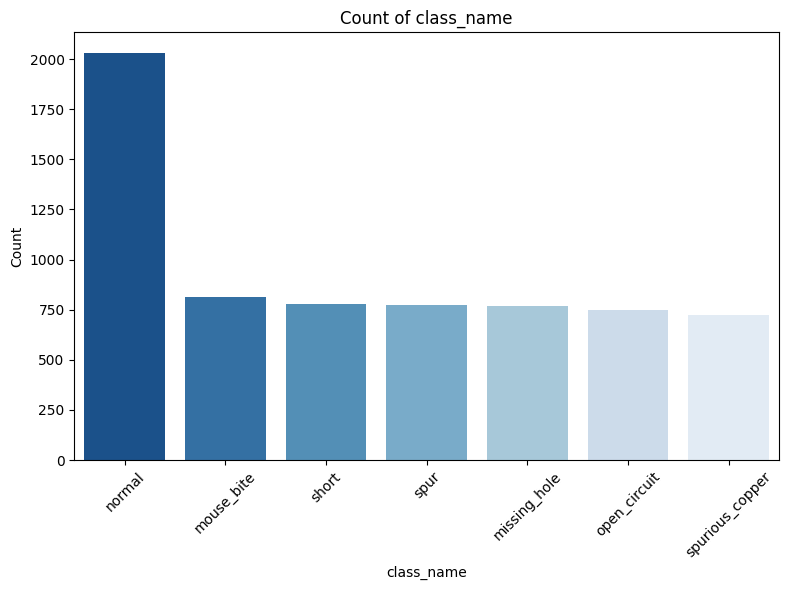

,class_name,count
0,normal,2032
1,mouse_bite,813
2,short,780
3,spur,775
4,missing_hole,768
5,open_circuit,750
6,spurious_copper,724


In [5]:
count_plot(df=df, x_col='class_name', rotation=45)
df['class_name'].value_counts().reset_index()

- Normal vs Defect

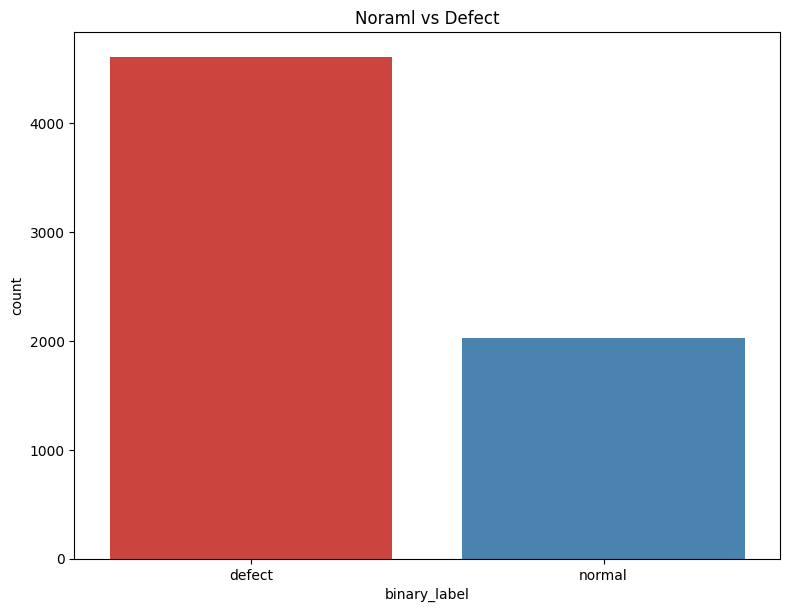

,binary_label
count,6642
unique,2
top,defect
freq,4610


In [6]:
df['binary_label'] = df['class_name'].apply(
    lambda x: 'normal' if x == 'normal' else 'defect'
)

palette = {
    "normal": sns.color_palette("Blues", 5)[3],
    "defect": sns.color_palette("Reds", 5)[3],
}

plt.figure(figsize=(8, 6))
sns.countplot(
    data=df,
    x="binary_label",
    palette=palette
)
plt.tight_layout()
plt.title("Noraml vs Defect")
plt.show()

df[['binary_label']].describe()

- 한 이미지에 있는 객체의 수

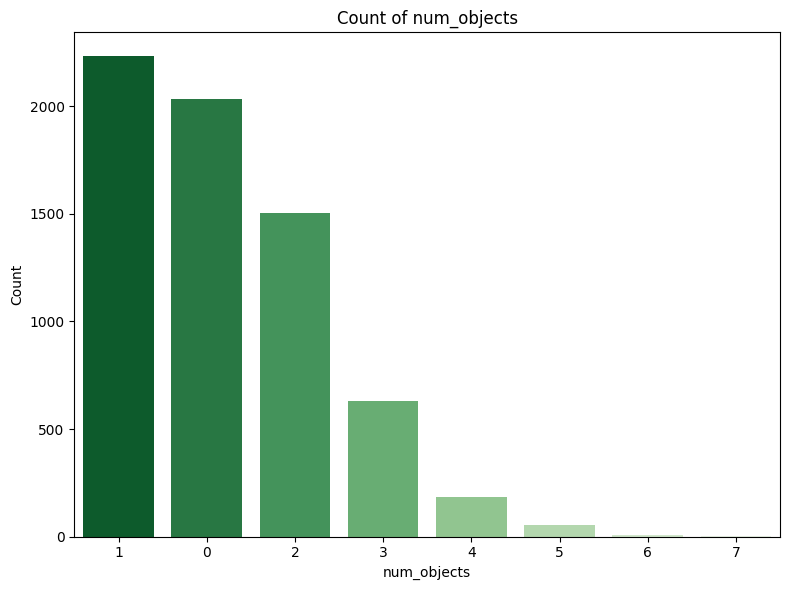

,num_objects,count,num_objects_ratio
0,1,2232,33.60
1,0,2032,30.59
2,2,1504,22.64
3,3,628,9.45
4,4,186,2.80
5,5,52,0.78
6,6,6,0.09
7,7,2,0.03


In [7]:
count_plot(df, x_col='num_objects', palette='Greens_r')
num_objects = df['num_objects'].value_counts().reset_index()
num_objects.columns = ['num_objects', 'count']

num_objects['num_objects_ratio'] = (
    num_objects['count'] / len(df) * 100
).round(2)
num_objects

In [8]:
df_defect = df[df["num_objects"] > 0]
class_count = df_defect["class_name"].value_counts().reset_index()
class_count.columns = ["class_name", "image_count"]
class_count

df_defect.groupby("class_name")["num_objects"].sum().sort_values(ascending=False)

class_name
short              1458
spur               1405
mouse_bite         1388
spurious_copper    1338
open_circuit       1297
missing_hole       1292
Name: num_objects, dtype: int64

- 결함 객체가 2개 이상 존재하는 이미지

In [9]:
df["multiple_objects"] = df["num_objects"] >= 2

multi_object = (
    df["multiple_objects"]
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

multi_object.columns = ["multiple_objects", "ratio"]
multi_object

,multiple_objects,ratio
0,False,64.197531
1,True,35.802469


In [10]:
def compute_bbox_area_ratios(df):
    area_ratios = []

    for _, row in df.iterrows():
        label_path = row["label_path"]

        if row["num_objects"] == 0 or label_path is None:
            area_ratios.append([])
            continue

        areas = []

        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                w = float(parts[3])
                h = float(parts[4])
                areas.append(w * h)

        area_ratios.append(areas)

    df["bbox_area_ratios"] = area_ratios
    return df

- 결함 이미지의 bounding box 면적 비율

In [11]:
not_normal = df[df['class_name'] != 'normal']

box_ratio = compute_bbox_area_ratios(not_normal)
box_ratio

,image_path,label_path,split,image_name,width,height,class_id,class_name,num_objects,binary_label,multiple_objects,bbox_area_ratios
0,dataset/roboflow/train/images/09_mouse_bite_02...,dataset/roboflow/train/labels/09_mouse_bite_02...,train,09_mouse_bite_02_jpg.rf.2ad00427015e5d9a724202...,640,640,1,mouse_bite,1,defect,False,[0.0038671875000000004]
2,dataset/roboflow/train/images/04_spurious_copp...,dataset/roboflow/train/labels/04_spurious_copp...,train,04_spurious_copper_17_jpg.rf.047c99c3de2b9a06c...,640,640,5,spurious_copper,1,defect,False,[0.0027850341796874997]
3,dataset/roboflow/train/images/08_missing_hole_...,dataset/roboflow/train/labels/08_missing_hole_...,train,08_missing_hole_06_jpg.rf.c1f1f443c5037dfface3...,640,640,0,missing_hole,2,defect,True,"[0.0022320556640625, 0.002135009765625]"
4,dataset/roboflow/train/images/06_short_08_jpg....,dataset/roboflow/train/labels/06_short_08_jpg....,train,06_short_08_jpg.rf.8a04fbeb9a716d3a7f937ddac4f...,640,640,3,short,4,defect,True,"[0.00263671875, 0.003306884765625, 0.002988281..."
5,dataset/roboflow/train/images/08_short_02_jpg....,dataset/roboflow/train/labels/08_short_02_jpg....,train,08_short_02_jpg.rf.9fb3f150c98d9042023cce40f74...,640,640,3,short,1,defect,False,[0.0073046875]
...,...,...,...,...,...,...,...,...,...,...,...,...
6637,dataset/roboflow/test/images/01_short_13_jpg.r...,dataset/roboflow/test/labels/01_short_13_jpg.r...,test,01_short_13_jpg.rf.49a8468cdb64cbb29958ce964dd...,640,640,3,short,2,defect,True,"[0.004200439453125, 0.007886962890625]"
6638,dataset/roboflow/test/images/08_short_06_jpg.r...,dataset/roboflow/test/labels/08_short_06_jpg.r...,test,08_short_06_jpg.rf.cd744e1ed6264abbdc464e25bf1...,640,640,3,short,3,defect,True,"[0.0042572021484375, 0.0044403076171875, 0.002..."
6639,dataset/roboflow/test/images/11_open_circuit_0...,dataset/roboflow/test/labels/11_open_circuit_0...,test,11_open_circuit_03_jpg.rf.8f3f97549279d345638c...,640,640,2,open_circuit,2,defect,True,"[0.00199951171875, 0.0005810546875]"
6640,dataset/roboflow/test/images/09_mouse_bite_06_...,dataset/roboflow/test/labels/09_mouse_bite_06_...,test,09_mouse_bite_06_jpg.rf.85e1ba7d83aed60e04b8d3...,640,640,1,mouse_bite,2,defect,True,"[0.0022827148437500003, 0.0027392578124999997]"


In [12]:
import numpy as np

not_normal["bbox_area_mean"] = not_normal["bbox_area_ratios"].apply(
    lambda x: np.mean(x) if len(x) > 0 else np.nan
)

not_normal["bbox_area_min"] = not_normal["bbox_area_ratios"].apply(
    lambda x: np.min(x) if len(x) > 0 else np.nan
)
not_normal[['bbox_area_mean', 'bbox_area_min']].describe()

,bbox_area_mean,bbox_area_min
count,4610.000000,4610.000000
mean,0.003002,0.002533
std,0.001833,0.001765
min,0.000032,0.000026
25%,0.001844,0.001376
50%,0.002639,0.002195
75%,0.003707,0.003208
max,0.021226,0.021226


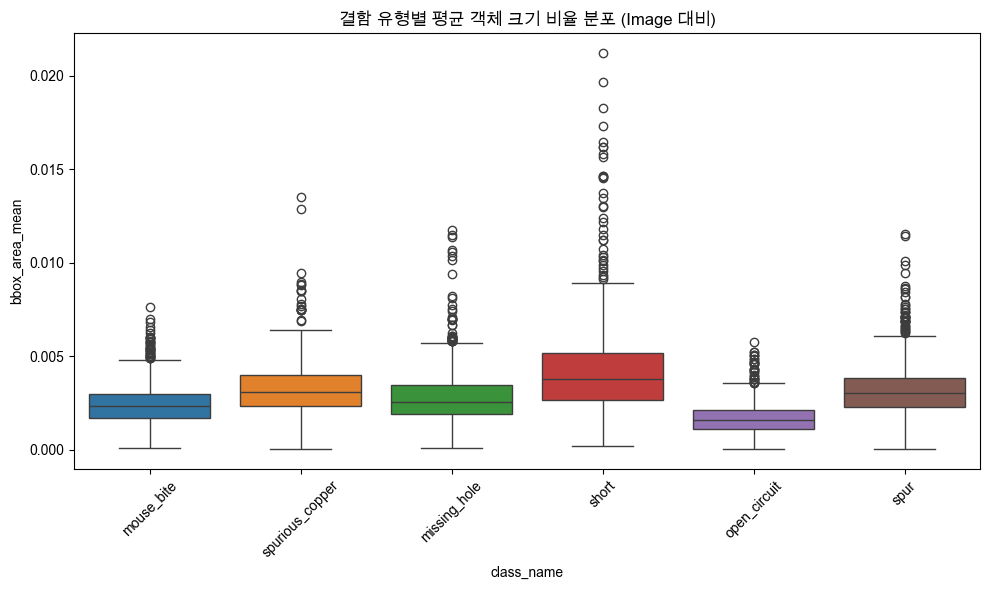

In [19]:
from src.utils import set_matplotlib_hangul

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=not_normal,
    x="class_name",
    y="bbox_area_mean",
    palette="tab10"
)
plt.xticks(rotation=45)
plt.title("결함 유형별 평균 객체 크기 비율 분포 (Image 대비)")
plt.tight_layout()
plt.show()

### Training

In [2]:
from src.training.train import train_model
from src.models.model_factory import ModelFactory
from src.utils.config import load_config

config_path = f"{PROJECT_ROOT}/configs/train_config.yaml"
config = load_config(config_path)
config

{'model': {'type': 'yolov8', 'size': 's', 'pretrained': True},
 'data': {'data_yaml': 'dataset/roboflow/data.yaml', 'img_size': 600},
 'training': {'epochs': 100,
  'batch_size': 32,
  'device': 'cuda',
  'workers': 8,
  'patience': 10,
  'save_period': -1,
  'save_dir': 'outputs'},
 'augmentation': {'enabled': False,
  'pcb_optimized': False,
  'exclude_classes': []},
 'wandb': {'enabled': True,
  'project': 'PCB_Detection',
  'suffix': 'roboflow_base'},
 'experiment': {'suffix': 'roboflow_base', 'seed': 42}}

In [5]:
training_results = train_model(config_path=config_path)

2026-01-13 03:03:07 - INFO - Starting training...
INFO:PCB_Detection:Starting training...
2026-01-13 03:03:07 - INFO - Config: /content/drive/MyDrive/likelion/PCB/configs/train_config.yaml
INFO:PCB_Detection:Config: /content/drive/MyDrive/likelion/PCB/configs/train_config.yaml
2026-01-13 03:03:07 - INFO - Project root: /content/drive/MyDrive/likelion/PCB
INFO:PCB_Detection:Project root: /content/drive/MyDrive/likelion/PCB
2026-01-13 03:03:07 - INFO - Working directory: /content/drive/MyDrive/likelion/PCB
INFO:PCB_Detection:Working directory: /content/drive/MyDrive/likelion/PCB
2026-01-13 03:03:07 - INFO - Logs will be saved to: /content/drive/MyDrive/likelion/PCB/logs/yolov8s-roboflow_base
INFO:PCB_Detection:Logs will be saved to: /content/drive/MyDrive/likelion/PCB/logs/yolov8s-roboflow_base
2026-01-13 03:03:07 - INFO - Seed fixed to 42
INFO:PCB_Detection:Seed fixed to 42
2026-01-13 03:03:07 - INFO - Using device: cuda
INFO:PCB_Detection:Using device: cuda
2026-01-13 03:03:07 - INFO -

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


2026-01-13 03:03:15 - INFO - W&B initialized for YOLO: project='PCB_Detection', name='yolov8s-roboflow_base'
INFO:PCB_Detection:W&B initialized for YOLO: project='PCB_Detection', name='yolov8s-roboflow_base'
2026-01-13 03:03:15 - INFO - Custom W&B callback registered for loss logging
INFO:PCB_Detection:Custom W&B callback registered for loss logging
2026-01-13 03:03:15 - INFO - Training parameters: {'data': '/content/drive/MyDrive/likelion/PCB/dataset/roboflow/data.yaml', 'epochs': 100, 'batch': 32, 'imgsz': 600, 'patience': 10, 'device': device(type='cuda'), 'workers': 8, 'save': True, 'save_period': -1, 'project': '/content/drive/MyDrive/likelion/PCB/outputs', 'name': 'yolov8s-roboflow_base', 'val': True, 'plots': False}
INFO:PCB_Detection:Training parameters: {'data': '/content/drive/MyDrive/likelion/PCB/dataset/roboflow/data.yaml', 'epochs': 100, 'batch': 32, 'imgsz': 600, 'patience': 10, 'device': device(type='cuda'), 'workers': 8, 'save': True, 'save_period': -1, 'project': '/con

engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/likelion/PCB/dataset/roboflow/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=600, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=weights/yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s-roboflow_base, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=False, pose=12.0, pretrained=True, pr

2026-01-13 03:08:40 - INFO - Epoch 0: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 0: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/100      7.49G      2.621      3.484      1.571         58        608: 14% ━╸────────── 26/182 6.7it/s 4.1s<23.3s

wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      2/100      7.49G      2.527      3.333      1.548         41        608: 100% ━━━━━━━━━━━━ 182/182 6.5it/s 28.0s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 1.9s0.2s
                   all        556        642      0.788      0.611      0.684      0.312


2026-01-13 03:09:11 - INFO - Epoch 1: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 1: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      3/100      7.52G      2.524      3.336      1.562         48        608: 13% ━╸────────── 23/182 7.1it/s 3.5s<22.5s

wandb: WARNING Tried to log to step 1 that is less than the current step 2. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      3/100      7.52G      2.502      3.232      1.523         28        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s0.2s
                   all        556        642      0.772      0.485      0.641      0.279


2026-01-13 03:09:41 - INFO - Epoch 2: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 2: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      4/100      7.52G      2.521      3.134      1.499         53        608: 15% ━╸────────── 28/182 6.7it/s 4.2s<22.9s

wandb: WARNING Tried to log to step 2 that is less than the current step 3. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      4/100      7.52G      2.444      3.074      1.489         23        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s0.3s
                   all        556        642      0.665      0.607      0.679      0.324


2026-01-13 03:10:10 - INFO - Epoch 3: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 3: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      5/100      7.52G      2.376      3.009      1.463         53        608: 18% ━━────────── 32/182 6.8it/s 4.8s<21.9s

wandb: WARNING Tried to log to step 3 that is less than the current step 4. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      5/100      7.52G      2.384      2.996      1.458         46        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s0.3s
                   all        556        642      0.819      0.708      0.774      0.374


2026-01-13 03:10:40 - INFO - Epoch 4: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 4: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      6/100      7.52G      2.281      2.762      1.406         36        608: 20% ━━────────── 36/182 7.0it/s 5.4s<20.8s

wandb: WARNING Tried to log to step 4 that is less than the current step 5. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      6/100      7.52G      2.292       2.79      1.417         23        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.839      0.743      0.823      0.387


2026-01-13 03:11:09 - INFO - Epoch 5: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 5: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/100      7.52G      2.292      2.794      1.408         52        608: 21% ━━╸───────── 38/182 6.8it/s 5.7s<21.3s

wandb: WARNING Tried to log to step 5 that is less than the current step 6. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      7/100      7.52G        2.3      2.803      1.406         36        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.862      0.779      0.825      0.406


2026-01-13 03:11:39 - INFO - Epoch 6: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 6: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      8/100      7.52G      2.239      2.697      1.407         58        608: 23% ━━╸───────── 42/182 6.9it/s 6.3s<20.2s

wandb: WARNING Tried to log to step 6 that is less than the current step 7. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      8/100      7.52G      2.221      2.692      1.373         24        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.867      0.821      0.864      0.429


2026-01-13 03:12:08 - INFO - Epoch 7: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 7: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      9/100      7.52G      2.205       2.66       1.37         44        608: 25% ━━━───────── 46/182 6.6it/s 6.9s<20.5s

wandb: WARNING Tried to log to step 7 that is less than the current step 8. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


      9/100      7.52G      2.241      2.726       1.38         45        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 1.9s0.2s
                   all        556        642      0.885      0.789      0.838      0.422


2026-01-13 03:12:37 - INFO - Epoch 8: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 8: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     10/100      7.52G      2.144      2.494      1.346         46        608: 29% ━━━───────── 52/182 6.7it/s 7.7s<19.4s

wandb: WARNING Tried to log to step 8 that is less than the current step 9. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     10/100      7.52G       2.18      2.604      1.362         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.876      0.818      0.838      0.415


2026-01-13 03:13:06 - INFO - Epoch 9: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 9: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     11/100      7.52G      2.157      2.629       1.36         46        608: 32% ━━━╸──────── 59/182 6.9it/s 8.8s<17.9s

wandb: WARNING Tried to log to step 9 that is less than the current step 10. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     11/100      7.52G      2.176      2.612      1.355         30        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.906      0.838      0.875      0.434


2026-01-13 03:13:36 - INFO - Epoch 10: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 10: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     12/100      7.52G      2.145      2.564      1.339         29        608: 35% ━━━━──────── 63/182 7.9it/s 9.1s<15.1s

wandb: WARNING Tried to log to step 10 that is less than the current step 11. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     12/100      7.52G      2.145      2.541      1.341         37        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.913      0.756      0.843      0.423


2026-01-13 03:14:05 - INFO - Epoch 11: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 11: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 11 that is less than the current step 12. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     13/100      7.52G       2.16      2.558      1.339         26        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 2.0s0.3s
                   all        556        642      0.871      0.798      0.854      0.452


2026-01-13 03:14:34 - INFO - Epoch 12: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 12: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     14/100      7.55G      2.122       2.47      1.326         63        608: 2% ──────────── 4/182 5.5it/s 0.7s<32.6s

wandb: WARNING Tried to log to step 12 that is less than the current step 13. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     14/100      7.55G      2.108      2.455      1.328         36        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s0.2s
                   all        556        642      0.897      0.757      0.841      0.431


2026-01-13 03:15:04 - INFO - Epoch 13: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 13: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     15/100      7.55G      2.078       2.71      1.331         54        608: 4% ╸─────────── 8/182 6.2it/s 1.3s<27.9s

wandb: WARNING Tried to log to step 13 that is less than the current step 14. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     15/100      7.55G      2.082      2.438      1.324         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.903      0.807      0.864      0.452


2026-01-13 03:15:33 - INFO - Epoch 14: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 14: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     16/100      7.55G       2.09      2.446      1.301         48        608: 7% ╸─────────── 12/182 6.4it/s 1.9s<26.4s

wandb: WARNING Tried to log to step 14 that is less than the current step 15. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     16/100      7.55G      2.081      2.465      1.321         38        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642       0.96      0.806      0.883      0.472


2026-01-13 03:16:02 - INFO - Epoch 15: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 15: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     17/100      7.55G       2.13      2.602      1.314         62        608: 9% ━─────────── 17/182 6.9it/s 2.6s<23.8s

wandb: WARNING Tried to log to step 15 that is less than the current step 16. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     17/100      7.55G      2.082      2.419      1.308         24        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.919      0.867      0.883       0.45


2026-01-13 03:16:32 - INFO - Epoch 16: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 16: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     18/100      7.55G      2.036      2.355       1.27         67        608: 12% ━─────────── 21/182 7.1it/s 3.2s<22.8s

wandb: WARNING Tried to log to step 16 that is less than the current step 17. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     18/100      7.55G      2.049      2.396      1.294         37        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642       0.92      0.836      0.884      0.484


2026-01-13 03:17:01 - INFO - Epoch 17: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 17: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     19/100      7.55G       2.08      2.534      1.307         51        608: 15% ━╸────────── 27/182 7.1it/s 4.0s<21.9s

wandb: WARNING Tried to log to step 17 that is less than the current step 18. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     19/100      7.55G      2.045      2.379      1.299         22        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.913      0.862      0.883       0.47


2026-01-13 03:17:30 - INFO - Epoch 18: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 18: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     20/100      7.55G      2.136      2.579      1.347         39        608: 19% ━━────────── 34/182 6.8it/s 5.1s<21.9s

wandb: WARNING Tried to log to step 18 that is less than the current step 19. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     20/100      7.55G      2.042      2.394      1.306         20        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.961      0.867      0.899      0.497


2026-01-13 03:17:59 - INFO - Epoch 19: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 19: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     21/100      7.55G      2.044      2.356      1.293         44        608: 21% ━━╸───────── 39/182 7.1it/s 5.8s<20.1s

wandb: WARNING Tried to log to step 19 that is less than the current step 20. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     21/100      7.55G      2.039      2.348      1.296         27        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.932       0.84      0.892      0.471


2026-01-13 03:18:28 - INFO - Epoch 20: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 20: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     22/100      7.55G      1.946      2.183      1.272         49        608: 24% ━━╸───────── 44/182 6.9it/s 6.6s<20.1s

wandb: WARNING Tried to log to step 20 that is less than the current step 21. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     22/100      7.55G      1.988      2.263      1.281         24        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 2.0s0.2s
                   all        556        642      0.939      0.883      0.899      0.486


2026-01-13 03:18:58 - INFO - Epoch 21: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 21: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     23/100      7.55G      2.012       2.28      1.287         50        608: 26% ━━━───────── 48/182 6.8it/s 7.1s<19.6s

wandb: WARNING Tried to log to step 21 that is less than the current step 22. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     23/100      7.55G       2.03       2.33      1.298         39        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 1.9s0.2s
                   all        556        642      0.927       0.86       0.89      0.478


2026-01-13 03:19:27 - INFO - Epoch 22: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 22: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     24/100      7.55G      1.994      2.332      1.282         44        608: 30% ━━━╸──────── 54/182 6.8it/s 8.0s<18.8s

wandb: WARNING Tried to log to step 22 that is less than the current step 23. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     24/100      7.55G      1.989      2.279      1.277         20        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.954      0.867      0.905      0.489


2026-01-13 03:19:56 - INFO - Epoch 23: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 23: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     25/100      7.55G      2.025      2.341      1.303         62        608: 34% ━━━━──────── 61/182 7.8it/s 8.9s<15.6s

wandb: WARNING Tried to log to step 23 that is less than the current step 24. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     25/100      7.55G      1.993      2.301      1.284         37        608: 100% ━━━━━━━━━━━━ 182/182 6.9it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.932      0.866      0.904      0.499


2026-01-13 03:20:25 - INFO - Epoch 24: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 24: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 24 that is less than the current step 25. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     26/100      7.55G      1.969      2.281      1.275         30        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.946      0.875      0.906      0.497


2026-01-13 03:20:54 - INFO - Epoch 25: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 25: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     27/100      7.55G      2.008      2.363        1.3         58        608: 3% ──────────── 5/182 6.0it/s 0.9s<29.5s

wandb: WARNING Tried to log to step 25 that is less than the current step 26. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     27/100      7.55G      1.985      2.269      1.285         27        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.971      0.865      0.913      0.509


2026-01-13 03:21:23 - INFO - Epoch 26: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 26: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     28/100      7.55G      1.948      2.184      1.252         65        608: 6% ╸─────────── 11/182 6.9it/s 1.7s<24.9s

wandb: WARNING Tried to log to step 26 that is less than the current step 27. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     28/100      7.55G      1.947      2.203      1.258         22        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642       0.94      0.888      0.901      0.502


2026-01-13 03:21:53 - INFO - Epoch 27: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 27: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     29/100      7.55G      1.877      2.158      1.239         48        608: 8% ╸─────────── 15/182 7.0it/s 2.3s<23.9s

wandb: WARNING Tried to log to step 27 that is less than the current step 28. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     29/100      7.55G      1.949      2.242      1.265         19        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        556        642      0.939      0.874      0.899       0.48


2026-01-13 03:22:22 - INFO - Epoch 28: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 28: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     30/100      7.55G      1.937      2.287      1.245         49        608: 12% ━─────────── 21/182 7.2it/s 3.2s<22.5s

wandb: WARNING Tried to log to step 28 that is less than the current step 29. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     30/100      7.55G      1.944      2.198      1.267         39        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.936      0.871      0.907      0.506


2026-01-13 03:22:51 - INFO - Epoch 29: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 29: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     31/100      7.55G      1.966      2.262      1.272         49        608: 15% ━╸────────── 27/182 7.1it/s 4.0s<21.9s

wandb: WARNING Tried to log to step 29 that is less than the current step 30. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     31/100      7.55G      1.953      2.249      1.271         38        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 2.0s0.2s
                   all        556        642      0.934      0.885      0.911      0.495


2026-01-13 03:23:20 - INFO - Epoch 30: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 30: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     32/100      7.55G      1.882       2.24       1.25         42        608: 18% ━━────────── 32/182 6.8it/s 4.9s<22.0s

wandb: WARNING Tried to log to step 30 that is less than the current step 31. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     32/100      7.55G      1.914      2.186      1.255         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.963      0.877      0.922      0.517


2026-01-13 03:23:50 - INFO - Epoch 31: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 31: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     33/100      7.55G      1.949      2.286      1.261         54        608: 20% ━━────────── 36/182 7.0it/s 5.4s<20.8s

wandb: WARNING Tried to log to step 31 that is less than the current step 32. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     33/100      7.55G      1.898      2.177      1.249         35        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642       0.95      0.885      0.913      0.509


2026-01-13 03:24:19 - INFO - Epoch 32: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 32: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     34/100      7.59G      1.961      2.231      1.255         51        608: 21% ━━╸───────── 39/182 7.1it/s 6.2s<20.3s

wandb: WARNING Tried to log to step 32 that is less than the current step 33. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     34/100      7.59G       1.92      2.192      1.245         36        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.952      0.875      0.909       0.52


2026-01-13 03:24:48 - INFO - Epoch 33: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 33: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     35/100      7.59G      1.882      2.125      1.222         62        608: 24% ━━╸───────── 44/182 6.7it/s 6.7s<20.7s

wandb: WARNING Tried to log to step 33 that is less than the current step 34. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     35/100      7.59G      1.888      2.156      1.236         30        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.948      0.883      0.914      0.507


2026-01-13 03:25:17 - INFO - Epoch 34: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 34: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     36/100      7.59G      1.897      2.219      1.242         63        608: 28% ━━━───────── 51/182 6.9it/s 7.6s<19.0s

wandb: WARNING Tried to log to step 34 that is less than the current step 35. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     36/100      7.59G      1.888      2.153      1.237         16        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642       0.95       0.88       0.91      0.505


2026-01-13 03:25:46 - INFO - Epoch 35: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 35: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     37/100      7.59G       1.82       1.99      1.216         35        608: 32% ━━━╸──────── 58/182 7.5it/s 8.5s<16.5s

wandb: WARNING Tried to log to step 35 that is less than the current step 36. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     37/100      7.59G      1.868      2.121       1.24         25        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.9s0.2s
                   all        556        642       0.94      0.887      0.912      0.511


2026-01-13 03:26:15 - INFO - Epoch 36: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 36: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     38/100      7.59G      1.802          2      1.224         48        608: 36% ━━━━──────── 66/182 6.5it/s 9.6s<17.7s

wandb: WARNING Tried to log to step 36 that is less than the current step 37. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     38/100      7.59G      1.829      2.055      1.221         28        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s0.2s
                   all        556        642      0.962      0.884      0.912       0.51


2026-01-13 03:26:44 - INFO - Epoch 37: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 37: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     39/100      7.59G      1.706      1.779       1.15         57        608: 1% ──────────── 2/182 3.6it/s 0.4s<50.7s

wandb: WARNING Tried to log to step 37 that is less than the current step 38. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     39/100      7.59G      1.877      2.154      1.235         32        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.955      0.883      0.915      0.524


2026-01-13 03:27:14 - INFO - Epoch 38: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 38: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     40/100      7.59G      1.848      1.949      1.257         60        608: 3% ──────────── 5/182 6.3it/s 0.8s<28.3s

wandb: WARNING Tried to log to step 38 that is less than the current step 39. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     40/100      7.59G      1.854      2.136      1.231         45        608: 100% ━━━━━━━━━━━━ 182/182 6.9it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.967      0.884      0.915      0.524


2026-01-13 03:27:43 - INFO - Epoch 39: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 39: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     41/100      7.59G      1.766      1.939      1.206         46        608: 5% ╸─────────── 10/182 6.4it/s 1.6s<27.0s

wandb: WARNING Tried to log to step 39 that is less than the current step 40. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     41/100      7.59G      1.833      2.071      1.223         23        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.967      0.884      0.912      0.518


2026-01-13 03:28:12 - INFO - Epoch 40: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 40: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     42/100      7.59G        1.9      2.232      1.235         57        608: 9% ━─────────── 17/182 6.9it/s 2.6s<23.8s

wandb: WARNING Tried to log to step 40 that is less than the current step 41. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     42/100      7.59G      1.835      2.102      1.223         31        608: 100% ━━━━━━━━━━━━ 182/182 6.9it/s 26.5s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.966       0.89      0.914      0.516


2026-01-13 03:28:41 - INFO - Epoch 41: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 41: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     43/100      7.59G      1.803      1.962      1.224         54        608: 14% ━╸────────── 25/182 6.9it/s 3.8s<22.8s

wandb: WARNING Tried to log to step 41 that is less than the current step 42. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     43/100      7.59G      1.833      2.068       1.22         19        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.965      0.894      0.919      0.516


2026-01-13 03:29:10 - INFO - Epoch 42: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 42: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     44/100      7.59G      1.823      2.079      1.211         41        608: 17% ━━────────── 31/182 7.0it/s 4.6s<21.6s

wandb: WARNING Tried to log to step 42 that is less than the current step 43. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     44/100      7.59G       1.81       2.05      1.219         24        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.967      0.897      0.922      0.529


2026-01-13 03:29:40 - INFO - Epoch 43: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 43: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     45/100      7.59G      1.805       2.05      1.217         52        608: 19% ━━────────── 34/182 6.8it/s 5.1s<21.9s

wandb: WARNING Tried to log to step 43 that is less than the current step 44. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     45/100      7.59G      1.786      1.997      1.216         26        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.964      0.888      0.919      0.521


2026-01-13 03:30:09 - INFO - Epoch 44: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 44: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     46/100      7.59G      1.836      2.106      1.211         58        608: 23% ━━╸───────── 41/182 7.2it/s 6.1s<19.5s

wandb: WARNING Tried to log to step 44 that is less than the current step 45. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     46/100      7.59G      1.807      2.047      1.207         31        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.958      0.893      0.921      0.529


2026-01-13 03:30:38 - INFO - Epoch 45: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 45: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     47/100      7.59G      1.762      1.964      1.206         37        608: 25% ━━━───────── 46/182 7.0it/s 6.8s<19.4s

wandb: WARNING Tried to log to step 45 that is less than the current step 46. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     47/100      7.59G      1.784      1.995      1.204         21        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 1.9s0.2s
                   all        556        642      0.966      0.873      0.914      0.522


2026-01-13 03:31:07 - INFO - Epoch 46: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 46: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     48/100      7.59G      1.807      2.048      1.211         58        608: 29% ━━━───────── 52/182 6.9it/s 7.7s<19.0s

wandb: WARNING Tried to log to step 46 that is less than the current step 47. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     48/100      7.59G      1.787       2.05      1.215         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.973      0.889      0.921      0.529


2026-01-13 03:31:36 - INFO - Epoch 47: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 47: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     49/100      7.59G      1.768      1.974      1.207         44        608: 32% ━━━╸──────── 59/182 7.9it/s 8.6s<15.7s

wandb: WARNING Tried to log to step 47 that is less than the current step 48. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     49/100      7.59G      1.773      2.024        1.2         41        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.969      0.894      0.933      0.533


2026-01-13 03:32:06 - INFO - Epoch 48: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 48: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     50/100      7.59G      1.759      2.005      1.198         57        608: 36% ━━━━──────── 65/182 7.1it/s 9.4s<16.6s

wandb: WARNING Tried to log to step 48 that is less than the current step 49. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     50/100      7.59G      1.762      2.022      1.201         21        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 1.9s0.2s
                   all        556        642      0.971      0.889      0.923      0.536


2026-01-13 03:32:35 - INFO - Epoch 49: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 49: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


wandb: WARNING Tried to log to step 49 that is less than the current step 50. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     51/100      7.59G      1.749      1.987      1.198         17        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.956      0.881       0.91      0.534


2026-01-13 03:33:04 - INFO - Epoch 50: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 50: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     52/100      7.59G      1.756      2.117      1.187         69        608: 2% ──────────── 4/182 5.4it/s 0.7s<33.0s

wandb: WARNING Tried to log to step 50 that is less than the current step 51. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     52/100      7.59G      1.774      2.032      1.209         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.963      0.892      0.919       0.53


2026-01-13 03:33:33 - INFO - Epoch 51: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 51: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     53/100      7.59G      1.696      1.848      1.186         48        608: 6% ╸─────────── 11/182 6.9it/s 1.7s<24.7s

wandb: WARNING Tried to log to step 51 that is less than the current step 52. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     53/100      7.59G      1.762      2.028        1.2         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.963      0.888      0.925       0.53


2026-01-13 03:34:03 - INFO - Epoch 52: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 52: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     54/100      7.59G      1.679       1.89      1.156         52        608: 9% ━─────────── 17/182 6.9it/s 2.6s<23.9s

wandb: WARNING Tried to log to step 52 that is less than the current step 53. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     54/100      7.59G       1.74      1.996      1.197         26        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        556        642      0.954      0.897      0.918      0.539


2026-01-13 03:34:32 - INFO - Epoch 53: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 53: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     55/100      7.59G      1.731      1.906      1.175         44        608: 13% ━╸────────── 23/182 7.3it/s 3.5s<21.9s

wandb: WARNING Tried to log to step 53 that is less than the current step 54. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     55/100      7.59G      1.753      2.016      1.192         29        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.1s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.979      0.886      0.926      0.548


2026-01-13 03:35:01 - INFO - Epoch 54: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 54: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     56/100      7.59G      1.739      2.042      1.186         41        608: 14% ━╸────────── 26/182 6.9it/s 3.9s<22.6s

wandb: WARNING Tried to log to step 54 that is less than the current step 55. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     56/100      7.59G      1.723      1.945      1.193         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.975      0.894      0.926      0.543


2026-01-13 03:35:30 - INFO - Epoch 55: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 55: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/100      7.59G      1.701      1.921      1.173         46        608: 17% ━━────────── 31/182 7.1it/s 4.6s<21.2s

wandb: WARNING Tried to log to step 55 that is less than the current step 56. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     57/100      7.59G      1.713      1.959      1.179         32        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 1.9s0.2s
                   all        556        642      0.965      0.902      0.931      0.541


2026-01-13 03:36:00 - INFO - Epoch 56: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 56: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/100      7.59G      1.745      1.925       1.19         54        608: 20% ━━────────── 36/182 6.8it/s 5.4s<21.5s

wandb: WARNING Tried to log to step 56 that is less than the current step 57. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     58/100      7.59G      1.713      1.955      1.179         30        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.3s
                   all        556        642      0.973      0.892      0.927      0.532


2026-01-13 03:36:29 - INFO - Epoch 57: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 57: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     59/100      7.59G      1.659      1.902      1.179         45        608: 24% ━━╸───────── 43/182 7.2it/s 6.4s<19.3s

wandb: WARNING Tried to log to step 57 that is less than the current step 58. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     59/100      7.59G      1.681      1.902      1.171         31        608: 100% ━━━━━━━━━━━━ 182/182 6.9it/s 26.5s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.979      0.888      0.922      0.528


2026-01-13 03:36:58 - INFO - Epoch 58: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 58: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     60/100      7.59G      1.725      2.006      1.178         44        608: 26% ━━━───────── 47/182 7.1it/s 7.4s<19.1s

wandb: WARNING Tried to log to step 58 that is less than the current step 59. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     60/100      7.59G      1.679      1.905      1.166         38        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.1s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.974      0.898      0.925      0.537


2026-01-13 03:37:27 - INFO - Epoch 59: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 59: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/100      7.59G      1.705      1.934      1.179         66        608: 30% ━━━╸──────── 54/182 6.8it/s 8.0s<18.7s

wandb: WARNING Tried to log to step 59 that is less than the current step 60. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     61/100      7.59G      1.686      1.947      1.171         22        608: 100% ━━━━━━━━━━━━ 182/182 6.9it/s 26.5s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.963      0.898      0.923      0.538


2026-01-13 03:37:56 - INFO - Epoch 60: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 60: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/100      7.59G      1.712      1.938      1.194         53        608: 34% ━━━━──────── 62/182 6.6it/s 9.2s<18.2s

wandb: WARNING Tried to log to step 60 that is less than the current step 61. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     62/100      7.59G      1.689      1.937      1.181         24        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        556        642      0.978      0.898      0.926      0.541


2026-01-13 03:38:25 - INFO - Epoch 61: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 61: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/100      7.59G      1.752      2.022      1.246         51        608: 0% ──────────── 0/182  0.2s

wandb: WARNING Tried to log to step 61 that is less than the current step 62. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     63/100      7.59G      1.652      1.902      1.163         32        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.961      0.896      0.921      0.538


2026-01-13 03:38:54 - INFO - Epoch 62: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 62: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     64/100      7.59G      1.601      1.862      1.126         34        608: 4% ──────────── 7/182 6.9it/s 1.1s<25.3s

wandb: WARNING Tried to log to step 62 that is less than the current step 63. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     64/100      7.59G      1.651        1.9      1.165         26        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.9s0.2s
                   all        556        642      0.976      0.899      0.924      0.539


2026-01-13 03:39:23 - INFO - Epoch 63: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 63: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/100      7.59G      1.513      1.651      1.119         53        608: 7% ╸─────────── 13/182 7.3it/s 2.0s<23.1s

wandb: WARNING Tried to log to step 63 that is less than the current step 64. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     65/100      7.59G      1.626      1.854      1.159         22        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.977      0.898      0.925       0.55


2026-01-13 03:39:53 - INFO - Epoch 64: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 64: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/100      7.59G      1.599      1.779       1.16         40        608: 9% ━─────────── 17/182 7.1it/s 2.6s<23.4s

wandb: WARNING Tried to log to step 64 that is less than the current step 65. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     66/100      7.59G       1.65      1.924      1.165         34        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.978      0.905      0.929      0.539


2026-01-13 03:40:22 - INFO - Epoch 65: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 65: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     67/100      7.59G      1.615      1.844      1.154         41        608: 13% ━╸────────── 23/182 7.0it/s 3.5s<22.6s

wandb: WARNING Tried to log to step 65 that is less than the current step 66. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     67/100      7.59G       1.63      1.891      1.162         39        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.983      0.897      0.926      0.539


2026-01-13 03:40:51 - INFO - Epoch 66: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 66: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     68/100      7.59G      1.578       1.75      1.151         63        608: 16% ━╸────────── 29/182 7.2it/s 4.3s<21.3s

wandb: WARNING Tried to log to step 66 that is less than the current step 67. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     68/100      7.59G      1.626      1.863      1.161         29        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.982      0.901      0.931      0.542


2026-01-13 03:41:20 - INFO - Epoch 67: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 67: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     69/100      7.59G        1.6      1.848      1.156         34        608: 19% ━━────────── 34/182 6.7it/s 5.2s<22.0s

wandb: WARNING Tried to log to step 67 that is less than the current step 68. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     69/100      7.59G       1.62      1.861      1.153         25        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.9s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.983      0.895      0.925       0.54


2026-01-13 03:41:49 - INFO - Epoch 68: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 68: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     70/100      7.59G      1.612      1.869      1.156         38        608: 21% ━━╸───────── 39/182 7.0it/s 5.9s<20.4s

wandb: WARNING Tried to log to step 68 that is less than the current step 69. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     70/100      7.59G      1.612       1.87       1.15         45        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.975      0.899      0.928      0.546


2026-01-13 03:42:19 - INFO - Epoch 69: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 69: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     71/100      7.59G      1.653      1.941      1.166         42        608: 24% ━━╸───────── 43/182 6.9it/s 6.5s<20.0s

wandb: WARNING Tried to log to step 69 that is less than the current step 70. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     71/100      7.59G      1.617      1.886      1.152         31        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        556        642      0.975      0.893      0.921      0.541


2026-01-13 03:42:48 - INFO - Epoch 70: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 70: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     72/100      7.59G      1.549      1.733      1.135         63        608: 27% ━━━───────── 49/182 7.0it/s 7.2s<18.9s

wandb: WARNING Tried to log to step 70 that is less than the current step 71. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     72/100      7.59G      1.579      1.789      1.145         21        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        556        642      0.968      0.904      0.927      0.543


2026-01-13 03:43:17 - INFO - Epoch 71: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 71: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     73/100      7.59G      1.609      1.822      1.151         58        608: 32% ━━━╸──────── 58/182 7.3it/s 8.4s<17.0s

wandb: WARNING Tried to log to step 71 that is less than the current step 72. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     73/100      7.59G      1.603       1.86      1.151         24        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.968      0.904      0.925       0.54


2026-01-13 03:43:46 - INFO - Epoch 72: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 72: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     74/100      7.59G      1.578      1.802      1.151         55        608: 35% ━━━━──────── 64/182 6.8it/s 9.3s<17.3s

wandb: WARNING Tried to log to step 72 that is less than the current step 73. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     74/100      7.59G      1.588      1.825      1.147         30        608: 100% ━━━━━━━━━━━━ 182/182 6.8it/s 26.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s0.2s
                   all        556        642      0.971      0.892      0.919      0.538


2026-01-13 03:44:15 - INFO - Epoch 73: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 73: Logged 14 metrics to W&B



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     75/100      7.59G      1.466      1.599      1.136         45        608: 0% ──────────── 0/182  0.2s

wandb: WARNING Tried to log to step 73 that is less than the current step 74. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


     75/100      7.59G      1.577      1.834      1.139         20        608: 100% ━━━━━━━━━━━━ 182/182 6.7it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        556        642      0.973        0.9      0.924      0.536
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 65, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.


2026-01-13 03:44:44 - INFO - Epoch 74: Logged 14 metrics to W&B
INFO:PCB_Detection:Epoch 74: Logged 14 metrics to W&B



75 epochs completed in 0.687 hours.
Optimizer stripped from /content/drive/MyDrive/likelion/PCB/outputs/yolov8s-roboflow_base/weights/last.pt, 22.5MB
Optimizer stripped from /content/drive/MyDrive/likelion/PCB/outputs/yolov8s-roboflow_base/weights/best.pt, 22.5MB

Validating /content/drive/MyDrive/likelion/PCB/outputs/yolov8s-roboflow_base/weights/best.pt...
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)


wandb: WARNING Tried to log to step 74 that is less than the current step 75. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.8it/s 1.6s0.2s
                   all        556        642      0.977      0.898      0.925       0.55
          missing_hole         74        116      0.991      0.935      0.947      0.644
            mouse_bite         51         86      0.958      0.907       0.94      0.557
          open_circuit         61        101      0.978      0.886      0.929      0.548
                 short         46         92      0.987      0.924      0.939      0.527
                  spur         66        115      0.971      0.879      0.899      0.522
       spurious_copper         74        132      0.977      0.856      0.899      0.505
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.8ms postprocess per image


2026-01-13 03:44:47 - INFO - Epoch 74: Logged 11 metrics to W&B
INFO:PCB_Detection:Epoch 74: Logged 11 metrics to W&B


lr/pg0,▅████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
lr/pg1,▅████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁
lr/pg2,▁▅███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇██████████████████
metrics/mAP50-95(B),▁▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇█████████████
metrics/precision(B),▁▆▆▇▇▇▇▇█▇█▇█▇▇█▇███████████████████████
metrics/recall(B),▁▃▃▅▇▆▆▇▇▇▇████████████▇████████████████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


2026-01-13 03:44:53 - INFO - Training completed successfully
INFO:PCB_Detection:Training completed successfully
2026-01-13 03:44:53 - INFO - Best model saved at: /content/drive/MyDrive/likelion/PCB/outputs/yolov8s-roboflow_base/weights/best.pt
INFO:PCB_Detection:Best model saved at: /content/drive/MyDrive/likelion/PCB/outputs/yolov8s-roboflow_base/weights/best.pt


In [ ]:
df = pd.read_csv("outputs/yolov8s-roboflow_base/results.csv")
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,305.694,2.97196,9.27846,1.82789,0.35427,0.46841,0.28402,0.11772,2.07060,7.16744,1.41189,0.000332,0.000332,0.000332
1,2,338.309,2.52661,3.33342,1.54763,0.78794,0.61147,0.68405,0.31228,1.88834,1.53902,1.33325,0.000658,0.000658,0.000658
2,3,367.752,2.50192,3.23161,1.52284,0.77173,0.48519,0.64105,0.27865,2.00205,1.87524,1.37924,0.000978,0.000978,0.000978
3,4,397.027,2.44416,3.07417,1.48883,0.66518,0.60709,0.67907,0.32381,1.79778,1.48641,1.29212,0.000970,0.000970,0.000970
4,5,426.339,2.38424,2.99622,1.45783,0.81871,0.70832,0.77397,0.37384,1.78964,1.17608,1.27364,0.000960,0.000960,0.000960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71,2354.980,1.61732,1.88550,1.15221,0.97475,0.89337,0.92150,0.54106,1.46055,0.59641,1.13302,0.000307,0.000307,0.000307
71,72,2383.920,1.57860,1.78910,1.14537,0.96824,0.90410,0.92656,0.54349,1.44928,0.59659,1.12548,0.000297,0.000297,0.000297
72,73,2412.950,1.60343,1.86038,1.15051,0.96780,0.90392,0.92506,0.54016,1.46068,0.60613,1.13204,0.000287,0.000287,0.000287
73,74,2442.080,1.58836,1.82480,1.14699,0.97083,0.89216,0.91912,0.53847,1.47582,0.60128,1.13540,0.000277,0.000277,0.000277


In [19]:
def line_plot(
    df,
    x,
    loss_groups,          
    figsize=(12, 6),
    rotation=None,
    title=None,
    ylabel="Loss"
):
    n_plots = len(loss_groups)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharex=True)

    if n_plots == 1:
        axes = [axes]

    for ax, (group_name, y_list) in zip(axes, loss_groups.items()):
        for y in y_list:
            sns.lineplot(data=df, x=x, y=y, ax=ax, label=y)

        ax.set_title(group_name)
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend()

        if rotation:
            ax.tick_params(axis="x", rotation=rotation)

    if title:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.92])
    else:
        fig.tight_layout()

    plt.show()

- Box Loss & DFL Loss

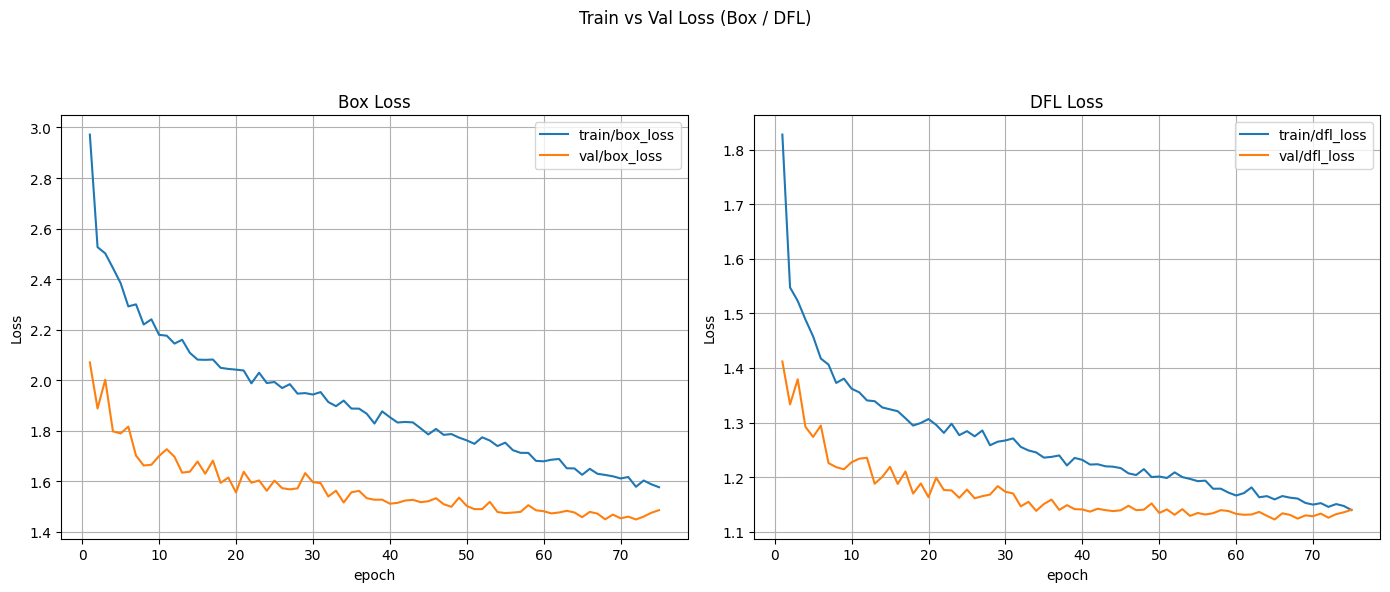

In [21]:
loss_groups = {
    "Box Loss": ["train/box_loss", "val/box_loss"],
    "DFL Loss": ["train/dfl_loss", "val/dfl_loss"]
}

line_plot(
    df,
    x="epoch",
    loss_groups=loss_groups,
    figsize=(14, 6),
    title="Train vs Val Loss (Box / DFL)"
)

### Inference

In [3]:
best_model_path = f"{PROJECT_ROOT}/outputs/yolov8s-roboflow_base/weights/best.pt"
test_path = f"{PROJECT_ROOT}/dataset/roboflow/test/"
save_dir = f"{PROJECT_ROOT}/runs"

print(f"Model Path: {best_model_path}")
print(f"Test Data Path: {test_path}")
print(f"Save Path: {save_dir}")

Model Path: /Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/PCB/outputs/yolov8s-roboflow_base/weights/best.pt
Test Data Path: /Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/PCB/dataset/roboflow/test/
Save Path: /Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/PCB/runs


In [5]:
from src.evaluation import Evaluator

# 평가 실행
evaluator = Evaluator(weights_path=best_model_path)

# Test 셋으로 평가 (mAP 계산)
evaluator = Evaluator(weights_path=best_model_path)
metrics = evaluator.evaluate(
    data_yaml='dataset/roboflow/data.yaml',
    split='test'
)

metrics_df = pd.DataFrame([metrics])
metrics_df

Ultralytics 8.3.252 🚀 Python-3.12.11 torch-2.9.1 CPU (Apple M3)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 168.4±33.2 MB/s, size: 34.2 KB)
val: Scanning /Users/mungughyeon/Library/CloudStorage/GoogleDrive-moonstalker9010@gmail.com/내 드라이브/likelion/PCB/dataset/roboflow/test/labels.cache... 276 images, 90 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 276/276 144.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 4.8s/it 1:264.8sss
                   all        276        322      0.971      0.877      0.911       0.55
          missing_hole         41         70          1      0.941      0.965      0.621
            mouse_bite         33         59       0.99      0.831      0.899      0.578
          open_circuit         19         37          1      0.862      0.932      0.557
                 short         31         50   

,mAP50,mAP50-95,precision,recall,fitness,per_class
0,0.911318,0.550244,0.971312,0.877033,0.550244,{'missing_hole': {'mAP50-95': 0.62148740921539...


In [6]:
import random

def visualize_predict(model_path, test_images_dir, label_dir, num_samples=5, conf=0.25, figsize=(15, 5)):

    model = YOLO(model_path)

    # 테스트 이미지 수집
    test_images = list(Path(test_images_dir).glob('*.jpg'))
    test_images.extend(list(Path(test_images_dir).glob('*.png')))

    if len(test_images) == 0:
        print("No images found")
        return

    # 레이블이 있는 이미지만 필터링 (정상 이미지 제외)
    images_with_labels = []
    for img_path in test_images:
        label_path = Path(label_dir) / f"{img_path.stem}.txt"
        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if len(lines) > 0:
                    images_with_labels.append(img_path)

    print(f"Found {len(images_with_labels)} images with defects")

    if len(images_with_labels) == 0:
        print("No images with labels found")
        return

    samples = random.sample(images_with_labels, min(num_samples, len(images_with_labels)))

    for img_path in samples:
        # 예측 수행
        results = model(str(img_path), conf=conf, verbose=False)
        result = results[0]

        # 원본 이미지 로드
        img_orig = cv2.imread(str(img_path))
        img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        h, w = img_orig.shape[:2]

        # Ground Truth 이미지
        img_gt = img_orig.copy()

        # 예측 이미지
        img_pred = img_orig.copy()

        # Ground Truth 레이블 읽기
        label_path = Path(label_dir) / f"{img_path.stem}.txt"
        gt_count = 0

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cls_id = int(parts[0])
                    cx, cy, bw, bh = map(float, parts[1:5])

                    # Normalized -> Pixel 좌표 변환
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)

                    cls_name = result.names[cls_id]

                    # Ground Truth는 녹색
                    color = (0, 255, 0)

                    # Ground Truth bbox 그리기
                    cv2.rectangle(img_gt, (x1, y1), (x2, y2), color, 4)
                    label = f"GT: {cls_name}"

                    # 레이블 배경
                    (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
                    cv2.rectangle(img_gt, (x1, y1-label_h-10), (x1+label_w, y1), color, -1)
                    cv2.putText(img_gt, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                    gt_count += 1

        # 예측 바운딩 박스 그리기
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf_score = float(box.conf[0])
            cls_id = int(box.cls[0])
            cls_name = result.names[cls_id]

            # 예측은 빨간색
            color = (255, 0, 0)

            cv2.rectangle(img_pred, (x1, y1), (x2, y2), color, 4)
            label = f"{cls_name} {conf_score:.2f}"

            # 레이블 배경
            (label_w, label_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
            cv2.rectangle(img_pred, (x1, y1-label_h-10), (x1+label_w, y1), color, -1)
            cv2.putText(img_pred, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # 시각화
        fig, axes = plt.subplots(1, 3, figsize=figsize)

        axes[0].imshow(img_orig)
        axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
        axes[0].axis('off')

        axes[1].imshow(img_gt)
        axes[1].set_title(f'Ground Truth ({gt_count} objects)', fontsize=14, fontweight='bold')
        axes[1].axis('off')

        axes[2].imshow(img_pred)
        axes[2].set_title(f'Predictions ({len(result.boxes)} detections)', fontsize=14, fontweight='bold')
        axes[2].axis('off')

        plt.suptitle(f'{img_path.name}', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

In [7]:
visualize_predict(
    model_path=best_model_path,
    test_images_dir=f"{test_path}/images",
    label_dir=f"{test_path}/labels",
    num_samples=2,  # 5개 이미지 시각화
    conf=0.25
)

Found 186 images with defects


KeyboardInterrupt: 